0.참고

https://www.ddanzi.com/index.php?mid=free&document_srl=751414970&statusList=HOT%2CHOTBEST%2CHOTAC%2CHOTBESTAC

#1.데이터셋과 프로젝트의 목적

1. 데이터셋
- 본인이 직접 "날리면"과 "바이든", "알 수 없는" 음성 데이터를 각각20개씩 녹음
- 총 60개의 데이터
- 음성 녹음의 정교성을 올리기 위해 골드웨이브 사용
- 샘플링 비율 8000, 스테레오 채널 설정

- 실제 테스트 데이터는 "굥 각하의 음성 중 ‘바이든은’ or 자칭 ‘날리면’ 부분을 컷팅한 오디오 파일"

2. 추가 데이터
- TTS기능을 사용하여 만든 음성데이터 12개

- 추가 데이터 확보를 위해 "데이터 증강(Augmentation) 사용"하여 또 (60+12)*5개 =360개 확보

3. 전체 데이터
- 갯수: 432개(72 + 360개)
- 본인 녹음: 60개(클래스당 20개)
- TTS기능 활용: 12개(클래스당 4개)
- 데이터 증강(5가지 기법): 72*5 = 288개(클래스당 144개)

4.골드웨이브 작업 모습

<img src=" https://lh3.googleusercontent.com/pw/AL9nZEVflsLWuFuw_1HXQjezpCs1UamB-2EMrBgxc-URnt3XSpJYoizaNM8yt4w6AYu43QNLljrJD_biDv2KFm4nSUFTvpu4WoYu3OX70qUPmR2ulZOY1UdjZP-m9A9AYOKU67vFhf1V6-3wk4Dug9zxpYFU=w480-h309-no?authuser=0 " width="600px">


<img src=" https://lh3.googleusercontent.com/pw/AL9nZEWCroww2NfUa_kH1mbHBS6ziNYyH8Kdbdp-GtXvNUYxkAU7Ul07jghi5vA3UK9cY4xuSjC-z5xeZvoNyZ03U1nvt6Pwkp3Wqg8XOFghWvwEtEjMkiRmdqZQt3VymcbKMUR1ypZwIDcPG1V255bXKkMs=w1152-h468-no?authuser=0 " width="600px">


<img src=" https://lh3.googleusercontent.com/pw/AL9nZEVi0SxB91t9_2YKv_JwSOJatGTvpYaIL6unJaUDQ1LMxF6Adz1yOlQ2CI-o0x0FQacDNMfF2I9QACAmgMrYIEBhOr4Es4p_sTLcxo60JNtxollL2owqtWZwAlG5Uowz4BeFmE7gfCGbCy94JvyPHn73=w404-h475-no?authuser=0 " width="600px">




#2.이론적 배경

1. CNN이용
- CNN은 데이터에서 패턴을 추출하는데 유용한 알고리즘으로 주로 이미지 분야에 특화되어 있음
- <font color='orange'> 이미지가 벡터라는 점을 감안한다면 오디오 샘플 또한 CNN 알고리즘을 적용할수 있음  </font>


![](https://img-cdn.ddanzi.com/files/attach/images/4258226/970/414/751/d597a04c6d2d03bc9d12724ae3e82d18.png)

2. 오디오 데이터 전처리
- CNN을 사용하기 위해서는  stft나 melspectrogram 피쳐맵 데이터 생성을 위한 전처리 과정이 필요함

3. 오디오 전처리도 귀찮다면?
- 1차원 CNN을 적용해볼 수 있음

4. 음성 데이터 증강(Augmentation)은 어떻게?

- 화이트 노이즈 추가
- shiftinf 추가
- Stretching 추가
- 피치 변경(음의 높이 또는 높낮이)

<음성 데이터 증강 참고 사이트>
https://data-engineer.tistory.com/31
https://dacon.io/codeshare/1340







#3.데이터 셋 확인

일단 시각화 먼저

총 3개의 시각화

1. 원본 음성파일 시각화

2. STFT결과 시각화

3. 멜스펙트럼 결과 시각화



In [ ]:
#라이브러리 import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob     #glob는 파일들의 리스트를 뽑을 때 사용하는 라이브러리
import pickle   #데이터를 저장하고 불러올때 매우 유용한 라이브러리

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten,Dropout, GlobalAvgPool2D

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from IPython.display import Audio, display
import librosa.display, librosa


In [ ]:
#1개의 오디오 파일만 시각화
# 실제 test해볼 파일을 지정해서 들어보기

file_path = '/content/drive/MyDrive/Colab Notebooks/8.음향관련/sj_sound_data/train/biden/biden1.wav'

y, sr = librosa.load(file_path)

#일단 들어보기
display(Audio(data=y,rate=sr))

###주의-음성데이터 최대길이 확인

음성 데이터의 길이가 제각각인 경우

음성 데이터 길이가 제일 긴 것을 기준으로 짧은 부분은 padding처리 해야 함

In [ ]:
# 데이터 타입과 shape을 잘 기억하기
# 제일 긴 음성데이터의 길이를 max_len변수에 저장

max_len = len(y)

max_len

33075

In [ ]:
#데이터 살펴보기
print(sr, y.shape)
print(y)

#숫자는 아래 해석 참고

22050 (33075,)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(33075,), dtype=float32)


##음성 데이터 해석

sr값은 22050: 1초에 22050개의 샘플이 기록되어있고(22050Hz)

음성길이가 약 1.x초 이므로

총 33148개의 샘플이 들어있는 것임

##3-1.음성데이터 시각화(FFT전)

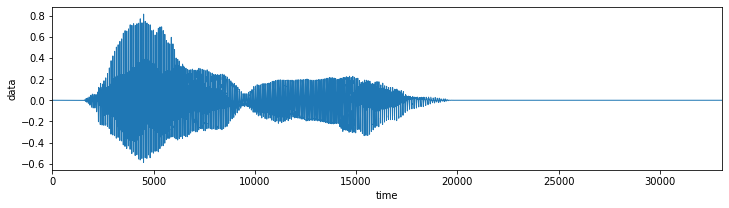

In [ ]:
# 푸리에 변환전 x축은 타임, y축은 진폭의 형태라고 생각하자!

plt.figure(figsize = (12, 3))
plt.plot(y, lw = 1)     #lw는 line width옵션을 의미
plt.xlabel("time")
plt.ylabel("data")
plt.xlim(0, len(y))
plt.show()

##3-2.학습에 사용될 음성데이터 확인

- train 데이터
- 총 3개의 class 존재함

1.주의점
<font color='orange'>  학습에 사용될 음성데이터의 길이가 모두 동일해야하니 전처리 필요 </font>



In [ ]:
#glob 라이브러리 사용
import glob

short = str('/content/drive/MyDrive/Colab Notebooks/8.음향관련/sj_sound_data/train/')

unknown_dir = glob.glob(short + "/unknown/*")
biden_dir = glob.glob(short +"/biden/*")
nali_dir = glob.glob(short +"/nali/*")

print("unknown_dir의 파일갯수:", len(unknown_dir))
print("biden_dir 파일갯수:", len(biden_dir))
print("nali_dir 파일갯수:", len(nali_dir))

unknown_dir의 파일갯수: 24
biden_dir 파일갯수: 24
nali_dir 파일갯수: 24


In [ ]:
##각각의 file_path를 리스트로

unknown_file_path = []
for i in range(len(unknown_dir)):
    unknown_file_path.append(unknown_dir[i])

biden_file_path = []
for i in range(len(biden_dir)):
    biden_file_path.append(biden_dir[i])

nali_file_path = []
for i in range(len(nali_dir)):
    nali_file_path.append(nali_dir[i])

#잘되었는지 1개의 nali_file_path 출력
print(len(nali_file_path))

24


In [ ]:
#하나만 출력해보기
unknown_file_path[23]

'/content/drive/MyDrive/Colab Notebooks/8.음향관련/sj_sound_data/train//unknown/clova_unknown (3).wav'

In [ ]:
#해당 파일을 librosa.load로 모두 불러와서 배열로 저장

#각각 3개의 클래스에 해당되는 데이터를 담을 배열 선언

unknown_array = []
#여기서 33075의 의미는 음성파일의 최대 길이
for i in range(len(unknown_file_path)):
    y, sr = librosa.load(unknown_file_path[i])
    if y.shape != max_len:
        zero_padding = tf.zeros(max_len- tf.shape(y), dtype=tf.float32)
        # zero_padding
        y = tf.concat([y, zero_padding],0)
    unknown_array.append(y)

unknown_array = np.array(unknown_array)



biden_array = []
#여기서 33075의 의미는 음성파일의 최대 길이
for i in range(len(biden_file_path)):
    y, sr = librosa.load(biden_file_path[i])
    if y.shape != max_len:
        zero_padding = tf.zeros(max_len- tf.shape(y), dtype=tf.float32)
        # zero_padding
        y = tf.concat([y, zero_padding],0)
    biden_array.append(y)

biden_array = np.array(biden_array)



nali_array = []
#여기서 33075의 의미는 음성파일의 최대 길이
for i in range(len(nali_file_path)):
    y, sr = librosa.load(nali_file_path[i])
    if y.shape != max_len:
        zero_padding = tf.zeros(max_len- tf.shape(y), dtype=tf.float32)
        # zero_padding
        y = tf.concat([y, zero_padding],0)
    nali_array.append(y)

nali_array = np.array(nali_array)


In [ ]:
# 넘파이 배열로 잘 저장되었는지 확인
# np.random.randint(6) # 0 or 1 or ~ or       0부터 5까지 랜덤한 숫자 1개

random_i =  np.random.randint(len(nali_file_path))
display(Audio(data=nali_array[random_i],rate=sr))


In [ ]:
#각각의 배열에 저장된 값 확인

print("배열shape:", nali_array.shape)

배열shape: (24, 33075)


##3-3.학습데이터 시각화

In [ ]:
#시각화를 위해 배열 차원 변경
nali_array_visual = nali_array.reshape(8,3, -1)
biden_array_visual = biden_array.reshape(8,3, -1)
unknown_array_visual = unknown_array.reshape(8,3, -1)

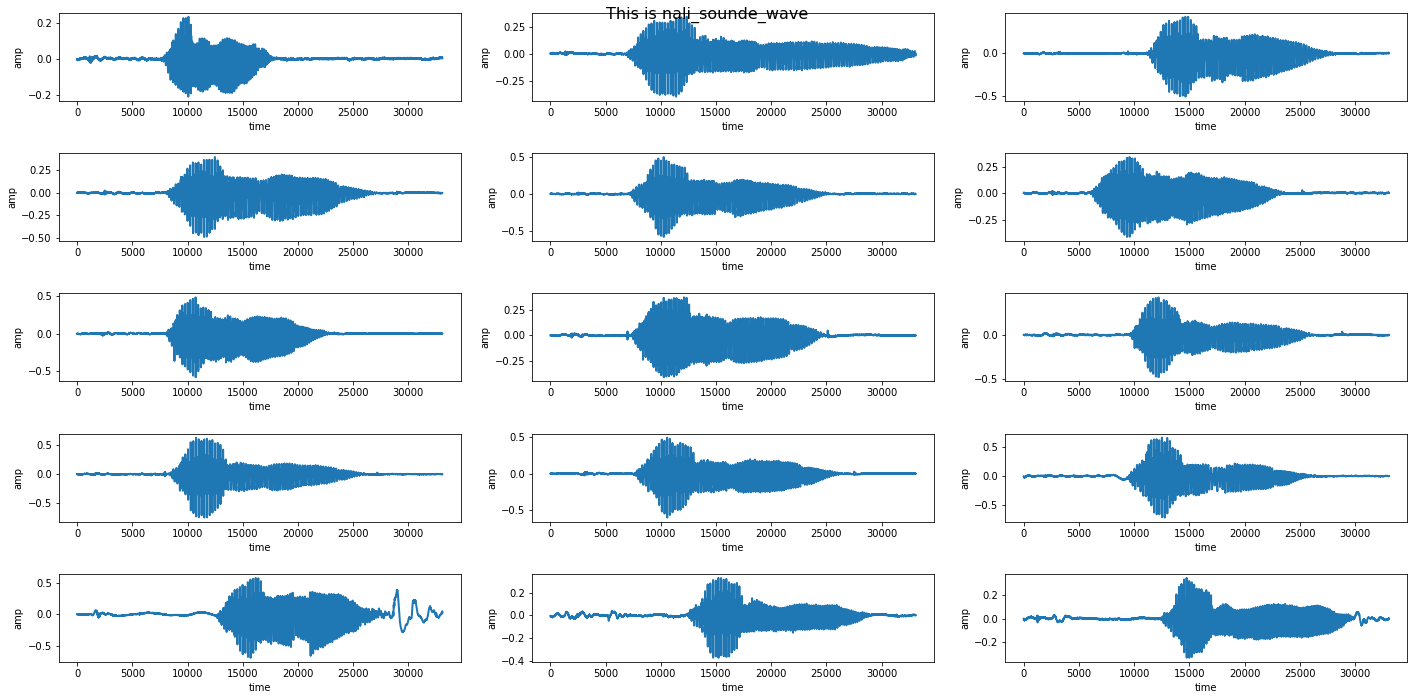

In [ ]:
#날리면 음성 데이터 시각화
#데이터가 많으니 앞 15개만 시각화

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

for i in range(5):
    for j in range(3):
        axes[i][j].plot(nali_array_visual[i][j], lw = 2)     #lw는 line width옵션을 의미
        # axes[i][j].set_title("sound_wave")
        axes[i][j].set_xlabel('time')
        axes[i][j].set_ylabel('amp')

fig.tight_layout(pad=2)
fig.suptitle("This is nali_sounde_wave", fontsize=16)

plt.show()

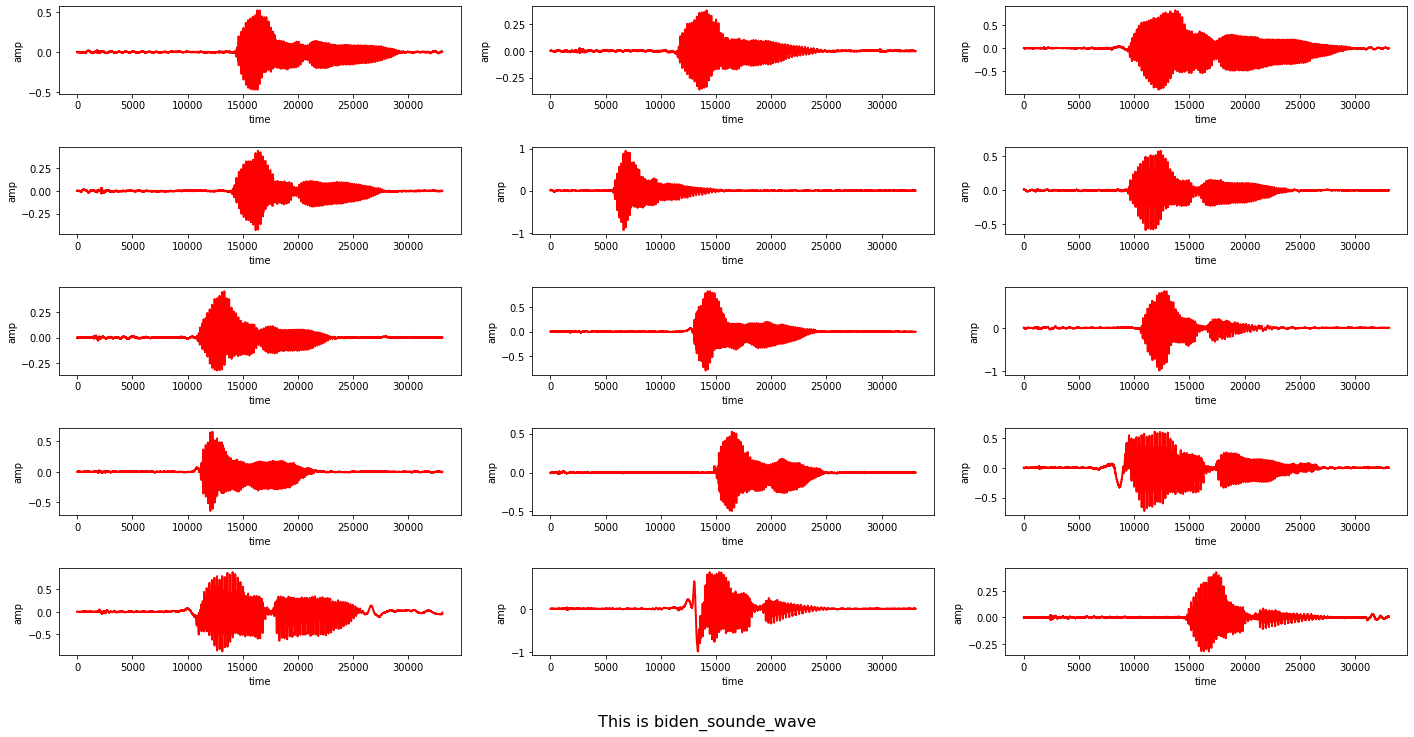

In [ ]:
#바이든 음성 데이터 시각화
#데이터가 많으니 앞 10개만 시각화

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

for i in range(5):
    for j in range(3):
        axes[i][j].plot(biden_array_visual[i][j], color='red',lw = 2)     #lw는 line width옵션을 의미
        # axes[i][j].set_title("sound_wave")
        axes[i][j].set_xlabel('time')
        axes[i][j].set_ylabel('amp')

fig.tight_layout(pad=2)
fig.suptitle("This is biden_sounde_wave", fontsize=16,  y = -0.01)

plt.show()

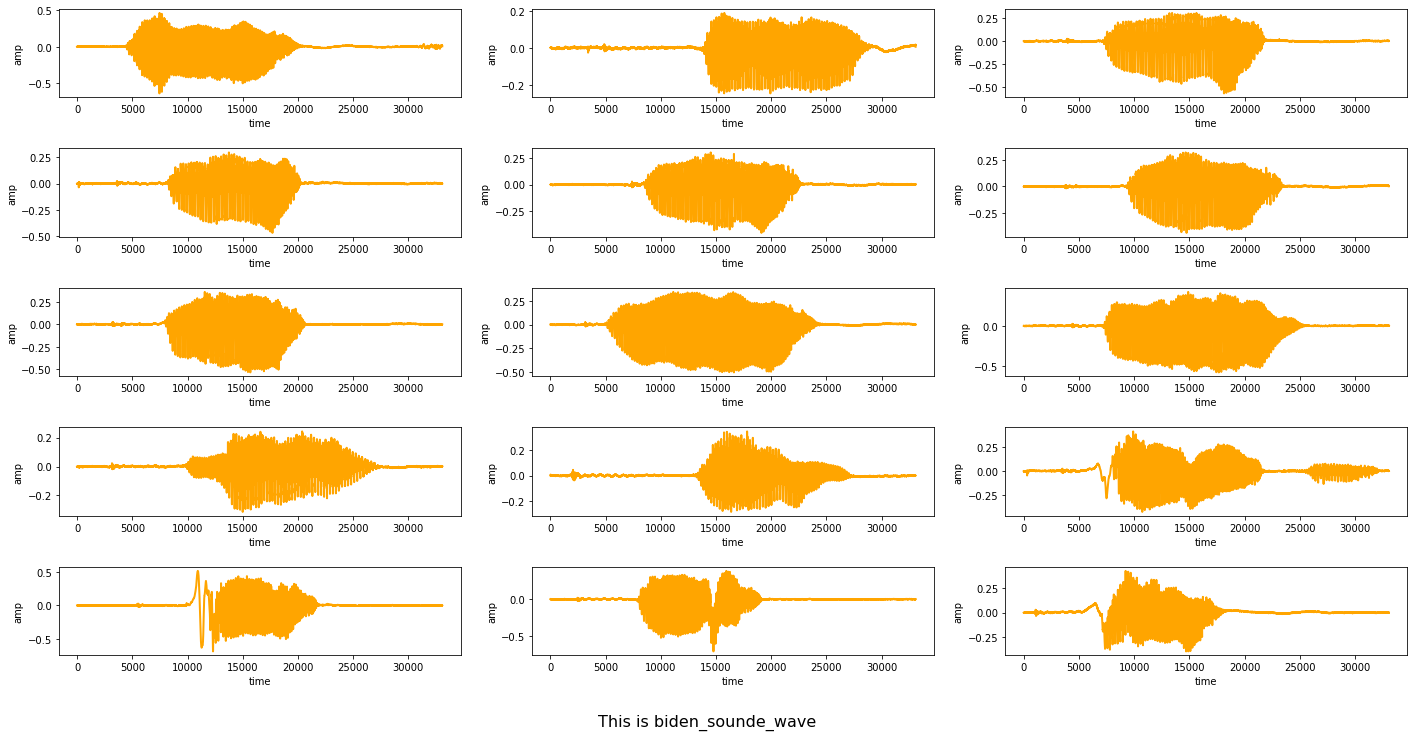

In [ ]:
#unknown 음성 데이터 시각화
#데이터가 많으니 앞 10개만 시각화

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

for i in range(5):
    for j in range(3):
        axes[i][j].plot(unknown_array_visual[i][j], color='orange',lw = 2)     #lw는 line width옵션을 의미
        # axes[i][j].set_title("sound_wave")
        axes[i][j].set_xlabel('time')
        axes[i][j].set_ylabel('amp')

fig.tight_layout(pad=2)
fig.suptitle("This is biden_sounde_wave", fontsize=16,  y = -0.01)

plt.show()

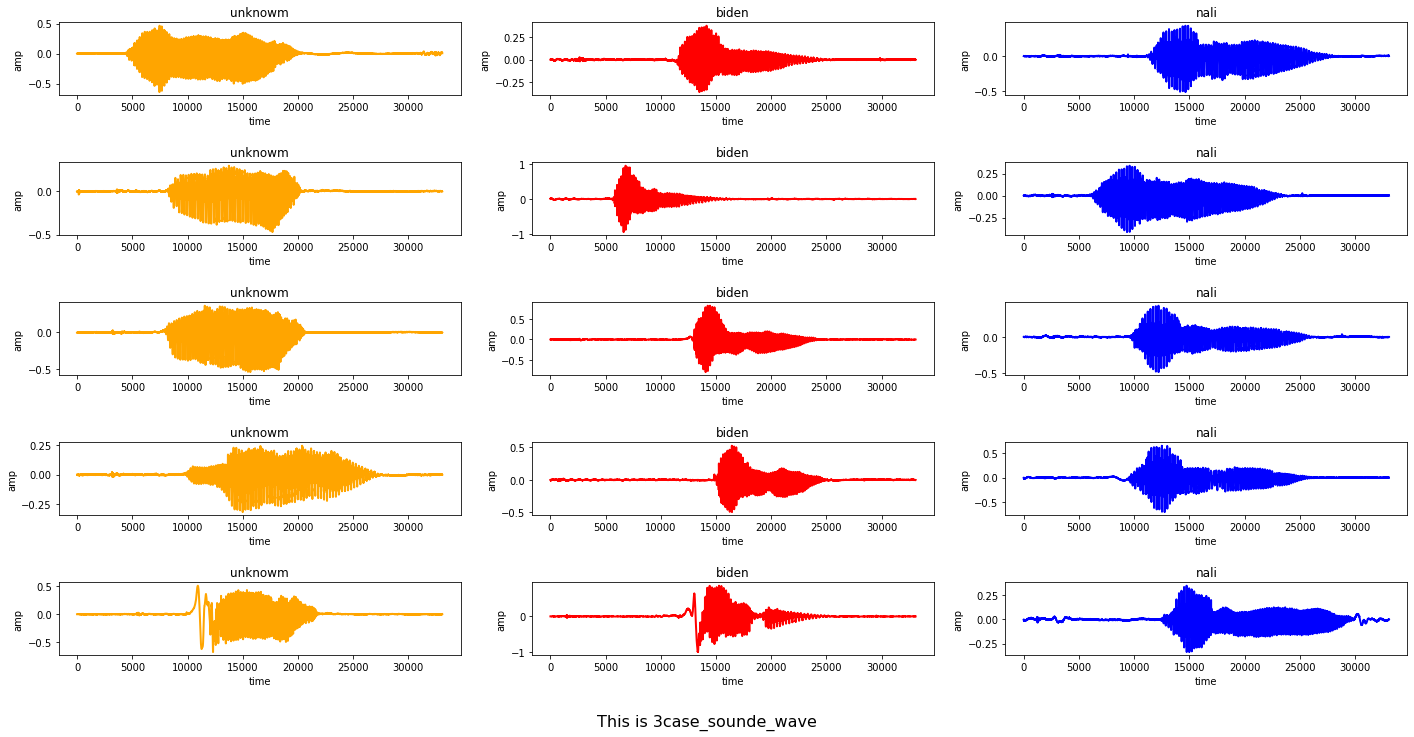

In [ ]:
#3개 클래스에서 하나씩 뽑아서 시각화 비교

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

for i in range(5):
    for j in range(3):
        if j==0:
            axes[i][j].plot(unknown_array_visual[i][j], color='orange',lw = 2)     #lw는 line width옵션을 의미
            axes[i][j].set_title("unknowm")
            axes[i][j].set_xlabel('time')
            axes[i][j].set_ylabel('amp')

        elif j==1:
            axes[i][j].plot(biden_array_visual[i][j], color='red',lw = 2)     #lw는 line width옵션을 의미
            axes[i][j].set_title("biden")
            axes[i][j].set_xlabel('time')
            axes[i][j].set_ylabel('amp')

        elif j==2:
            axes[i][j].plot(nali_array_visual[i][j], color='blue',lw = 2)     #lw는 line width옵션을 의미
            axes[i][j].set_title("nali")
            axes[i][j].set_xlabel('time')
            axes[i][j].set_ylabel('amp')

fig.tight_layout(pad=2)
fig.suptitle("This is 3case_sounde_wave", fontsize=16,  y = -0.01)

plt.show()

##3-4.스펙트럼 분석

- 시간에 따른 진폭파형으로는 분석이 불가능
- STFT(Short-Time Fourier Transform)을 실시

- STFT의 값은 너무 미세해서 차이를 파악하고 관찰하기 쉽지 않음

- 따라서 데시벨로 변환한 다음 시각화하는 것이 일반적


In [ ]:
# window는 STFT에 사용할 윈도우의 종류
# n_fft는 윈도우의 길이, 그리고 hop length는 얼마나 겹칠 것인지를 설정

nali_sample = librosa.stft(nali_array[1], n_fft=2048, window='hann', hop_length=512)
nali_sample.shape


(1025, 65)

In [ ]:
nali_array[1].shape

(33075,)

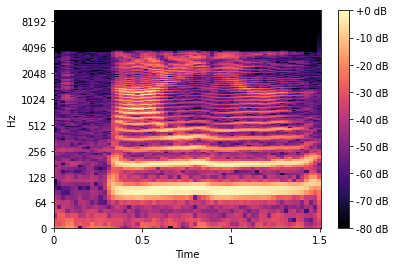

In [ ]:
# 데시벨 값으로 변환하지 않으면
#스펙트럼 변환 후 시각화(librosa라이브러리 활용)
nali_spec = librosa.amplitude_to_db(np.abs(nali_sample), ref=np.max)

librosa.display.specshow(nali_spec,  x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
#이제 전체 데이터를 STFT한 다음 시각화 해보기
#STFT값과 데시벨로 변환한 spec값을 각각 저장

nali_stft = []  #SFT값을 저장할 리스트
nali_spec = []  #SFT값을 데시벨로 바꾸어 저장할 리스트
for i in range(len(nali_array)):
    temp1 = librosa.stft(nali_array[i], n_fft=2048, window='hann', hop_length=512)
    nali_stft.append(temp1)
    nali_spec.append(librosa.amplitude_to_db(np.abs(temp1), ref=np.max))

#리스트를 넘파이 배열로
nali_stft = np.array(nali_stft)
nali_spec = np.array(nali_spec)

biden_stft = []
biden_spec = []
for i in range(len(biden_array)):
    temp2 = librosa.stft(biden_array[i], n_fft=2048, window='hann', hop_length=512)
    biden_stft.append(temp2)
    biden_spec.append(librosa.amplitude_to_db(np.abs(temp2), ref=np.max))

#리스트를 넘파이 배열로
biden_stft = np.array(biden_stft)
biden_spec = np.array(biden_spec)

unknown_stft = []
unknown_spec = []
for i in range(len(unknown_array)):
    temp3 = librosa.stft(unknown_array[i], n_fft=2048, window='hann', hop_length=512)
    unknown_stft.append(temp3)
    unknown_spec.append(librosa.amplitude_to_db(np.abs(temp3), ref=np.max))

#리스트를 넘파이 배열로
unknown_stft = np.array(unknown_stft)
unknown_spec = np.array(unknown_spec)

In [ ]:
#각 배열의 shape확인

print("nali_stft 의 shape:", nali_stft.shape)
print("nali_spec 의 shape:", nali_spec.shape)

print("biden_stft 의 shape:", biden_stft.shape)
print("biden_spec 의 shape:", biden_spec.shape)

print("unknown_stft 의 shape:", unknown_stft.shape)
print("unknown_spec 의 shape:", unknown_spec.shape)

nali_stft 의 shape: (24, 1025, 65)
nali_spec 의 shape: (24, 1025, 65)
biden_stft 의 shape: (24, 1025, 65)
biden_spec 의 shape: (24, 1025, 65)
unknown_stft 의 shape: (24, 1025, 65)
unknown_spec 의 shape: (24, 1025, 65)


##3-5.스펙트럼 분석결과 시각화



In [ ]:
unknown_spec_visual = unknown_spec
biden_spec_visual = biden_spec
nali_spec_visual = nali_spec

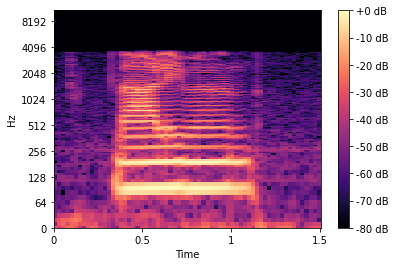

In [ ]:
librosa.display.specshow(nali_spec_visual[7],  x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')


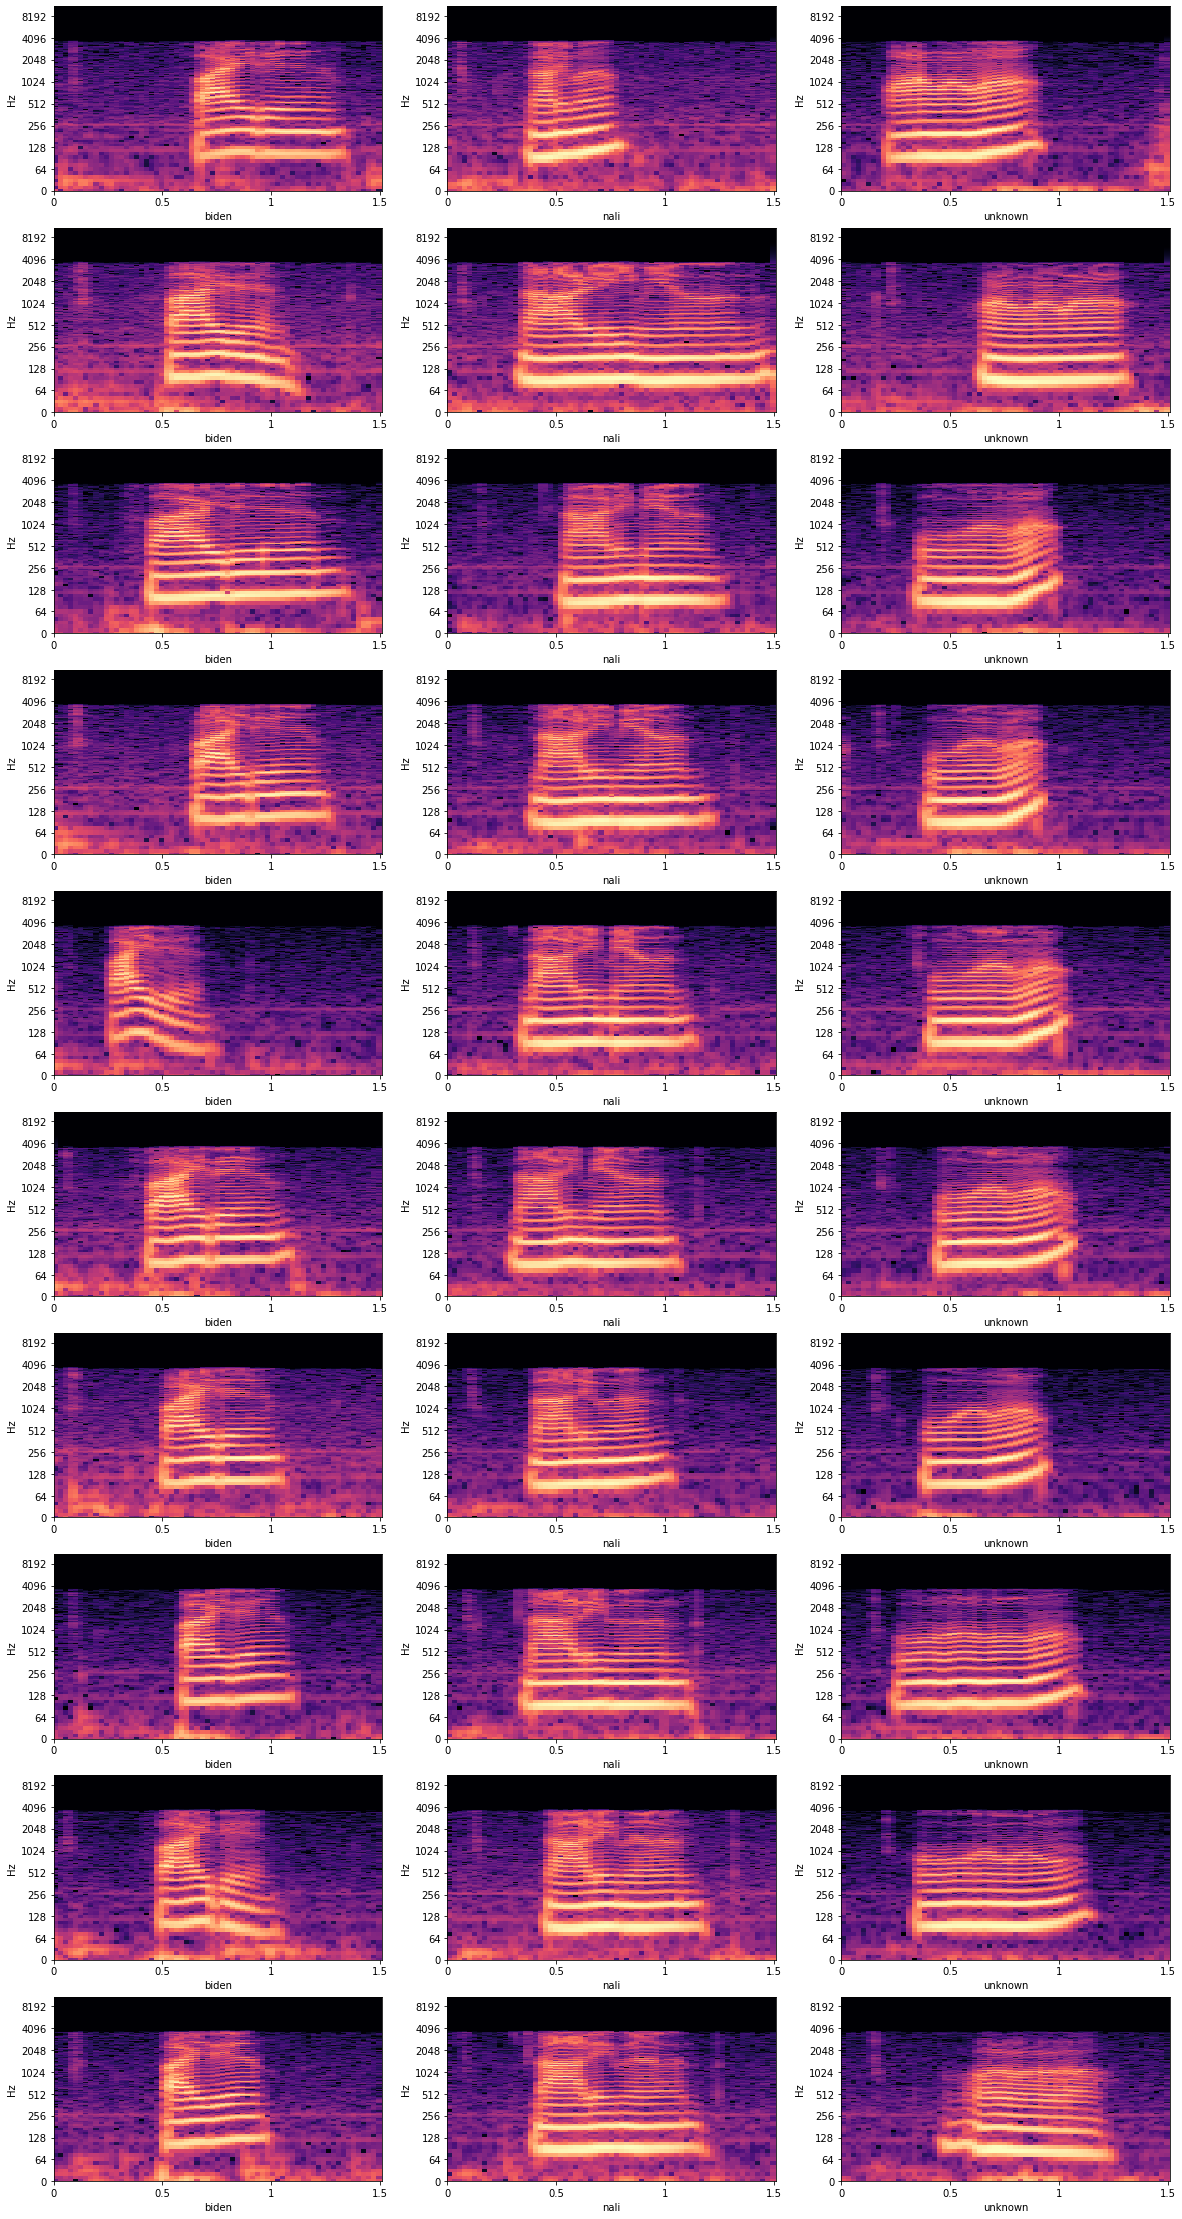

In [ ]:
#3개 클래스에서 각각 10개씩 총 30개 STFT 시각화 비교

nali_num=0
biden_num=0
unknown_num=0
plt.figure(figsize=(20,40))

for i in range(1,31):

    plt.subplot(10,3,i)
    if i%3 == 0:
        librosa.display.specshow(unknown_spec[unknown_num],  x_axis='time', y_axis='log')
        plt.xlabel("unknown")
        unknown_num = unknown_num +1

    elif i%3 == 1:
        librosa.display.specshow(biden_spec[biden_num],  x_axis='time', y_axis='log')
        plt.xlabel("biden")
        biden_num = biden_num +1

    elif i%3 == 2:
        librosa.display.specshow(nali_spec[nali_num],  x_axis='time', y_axis='log')
        plt.xlabel("nali")
        nali_num = nali_num +1



##3-6.멜스펙트럼으로 변환 후 시각화

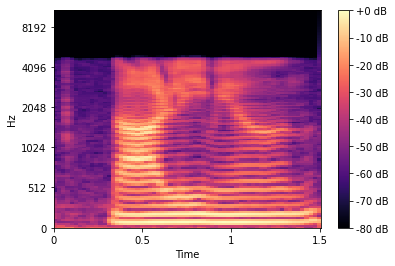

In [ ]:
#하나만 멜 스펙트럼으로 변환해보기

S = librosa.feature.melspectrogram(nali_array[1], sr=sr, n_mels=128, fmax=8000)

# db(데시벨)로 변환하기 위해 power_to_db()메서드 사용
mel_spec = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='mel' )
plt.colorbar(format='%+2.0f dB')
plt.show()

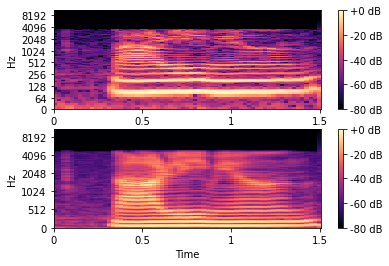

In [ ]:
#STFT와 멜 스펙트럼 변환 차이 살펴보기

plt.subplot(2,1,1)
plt.xlabel("STFT")
nali_stft1 = librosa.stft(nali_array[1], n_fft=2048, window='hann', hop_length=512)
nali_spec = librosa.amplitude_to_db(np.abs(nali_stft1), ref=np.max)
librosa.display.specshow(nali_spec,  x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')


plt.subplot(2,1,2)
plt.xlabel("melspec")
nali_mel_spec1 = librosa.feature.melspectrogram(nali_array[1], sr=sr, n_mels=128, fmax=8000)
nali_mel_spec1_db = librosa.power_to_db(nali_mel_spec1, ref=np.max)
librosa.display.specshow(nali_mel_spec1_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.show()


In [ ]:
# 전체 데이터 멜 스펙트럼으로 변환

#Mel Scale Spectrum값과 데시벨로 변환한 mel_db값을 각각 저장

nali_mel_spec = []  #Mel Scale Spectrum값을 저장할 리스트
nali_mel_db = []  #mMel Scale Spectrum값을 데시벨로 바꾸어 저장할 리스트
for i in range(len(nali_array)):
    temp1 = librosa.feature.melspectrogram(nali_array[i], sr=sr, n_mels=128, fmax=8000)
    nali_mel_spec.append(temp1)
    nali_mel_db.append(librosa.amplitude_to_db(np.abs(temp1), ref=np.max))

#리스트를 넘파이 배열로
nali_mel_spec = np.array(nali_mel_spec)
nali_mel_db = np.array(nali_mel_db)


biden_mel_spec = []  #Mel Scale Spectrum값을 저장할 리스트
biden_mel_db = []  #mMel Scale Spectrum값을 데시벨로 바꾸어 저장할 리스트
for i in range(len(biden_array)):
    temp2 = librosa.feature.melspectrogram(biden_array[i], sr=sr, n_mels=128, fmax=8000)
    biden_mel_spec.append(temp2)
    biden_mel_db.append(librosa.amplitude_to_db(np.abs(temp2), ref=np.max))

#리스트를 넘파이 배열로
biden_mel_spec = np.array(biden_mel_spec)
biden_mel_db = np.array(biden_mel_db)


unknown_mel_spec = []  #Mel Scale Spectrum값을 저장할 리스트
unknown_mel_db = []  #mMel Scale Spectrum값을 데시벨로 바꾸어 저장할 리스트
for i in range(len(unknown_array)):
    temp3 = librosa.feature.melspectrogram(unknown_array[i], sr=sr, n_mels=128, fmax=8000)
    unknown_mel_spec.append(temp3)
    unknown_mel_db.append(librosa.amplitude_to_db(np.abs(temp3), ref=np.max))

#리스트를 넘파이 배열로
unknown_mel_spec = np.array(unknown_mel_spec)
unknown_mel_db = np.array(unknown_mel_db)


In [ ]:
#각 배열의 shape확인

print("nali_stft 의 shape:", nali_mel_spec.shape)
print("nali_spec 의 shape:", nali_mel_db.shape)

print("biden_stft 의 shape:", biden_mel_spec.shape)
print("biden_spec 의 shape:", biden_mel_db.shape)

print("unknown_stft 의 shape:", unknown_mel_spec.shape)
print("unknown_spec 의 shape:", unknown_mel_db.shape)

nali_stft 의 shape: (24, 128, 65)
nali_spec 의 shape: (24, 128, 65)
biden_stft 의 shape: (24, 128, 65)
biden_spec 의 shape: (24, 128, 65)
unknown_stft 의 shape: (24, 128, 65)
unknown_spec 의 shape: (24, 128, 65)


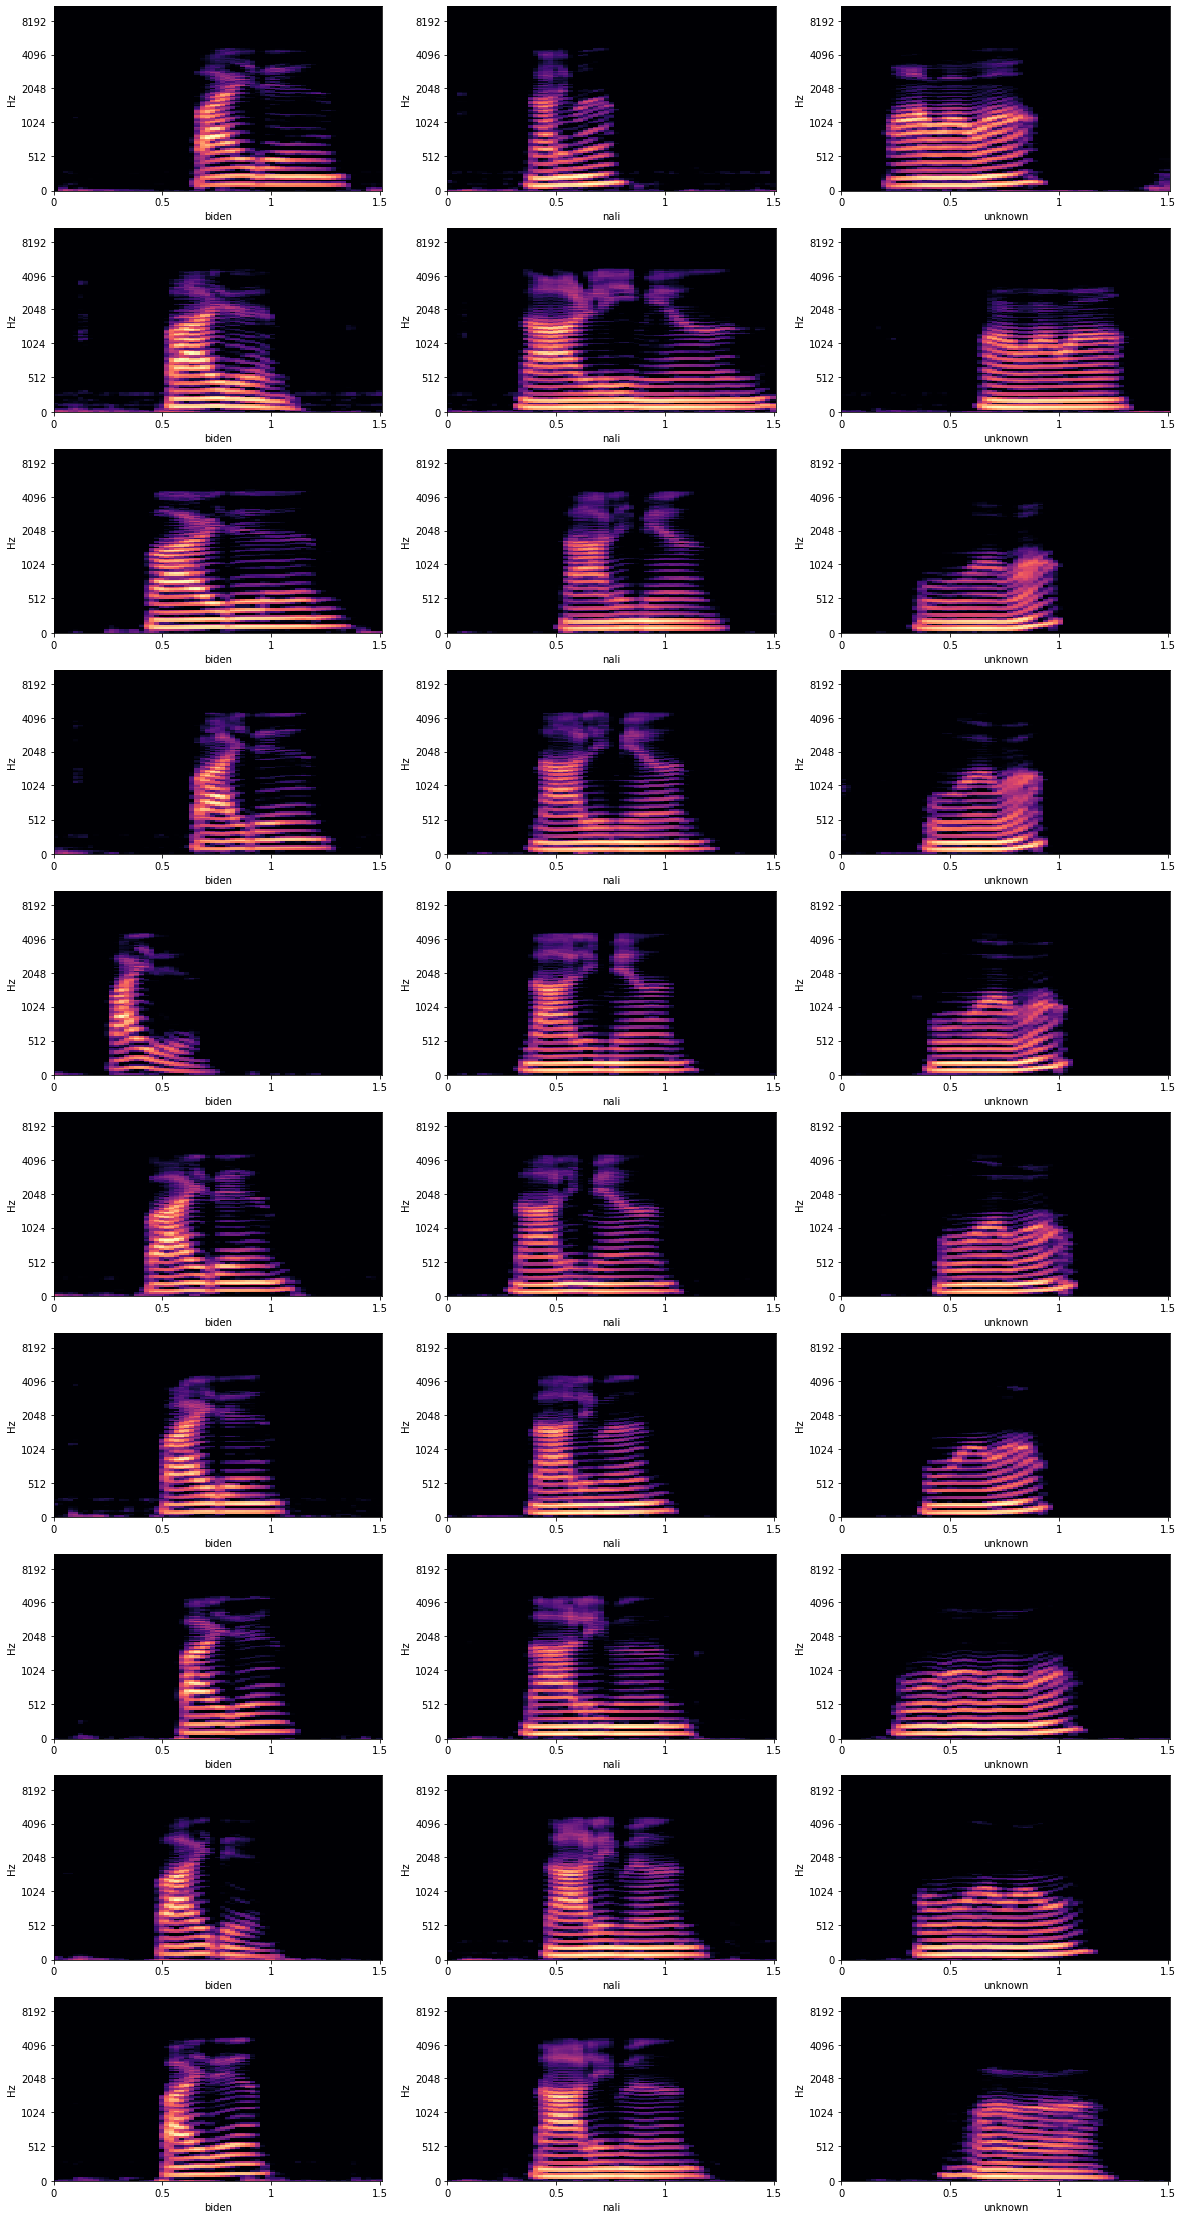

In [ ]:
#3개 클래스에서 각각 10개씩 총 30개 STFT 시각화 비교

nali_num=0
biden_num=0
unknown_num=0
plt.figure(figsize=(20,40))

for i in range(1,31):

    plt.subplot(10,3,i)
    if i%3 == 0:
        librosa.display.specshow(unknown_mel_db[unknown_num],  x_axis='time', y_axis='mel')
        plt.xlabel("unknown")
        unknown_num = unknown_num +1

    elif i%3 == 1:
        librosa.display.specshow(biden_mel_db[biden_num],  x_axis='time', y_axis='mel')
        plt.xlabel("biden")
        biden_num = biden_num +1

    elif i%3 == 2:
        librosa.display.specshow(nali_mel_db[nali_num],  x_axis='time', y_axis='mel')
        plt.xlabel("nali")
        nali_num = nali_num +1

##3-7.데이터 분석의 결과

1. STFT서는 잘 드러나지 않았지만 Mel spectogram으로 만들어 시각화 해보면 바이든 음성과 날리면 음성의 차이를 볼 수 있음

- '바이든'은 전체 주파수의 색상이 좀 더 고르게 분포되어
-  바이든의 경우 사람의 음성주파수가 저-고까지 골고루 사용되면서 특히 512 - 1024HZ대역의 색상이 도드라 보임

- '날리면'은 512 이하의 저주파수의 색상이 도드라 보임을 알 수있음

2. 이는 반면 '날리면'의 경우 음성주파수의 저주파 영역이 좀 더 강조되서 사용된다는 결론

3. 또한, 바이든의 경우 주파수가 시간대비 비대칭 적인 모습이 강한 반면, 날리면의 경우 주파수가 시간대비 좌우 대칭적인 모습이 좀 더 강하게 나타남을 볼 수 있음

5. 물론 여기까지는 실험자의 음성과 네이버 클로버 음성만 가지고 한 결과~

##3-8.테스트 데이터 분석해보기

In [ ]:
# 실제 test해볼 파일을 지정해서 들어보기

test_file_path = '/content/drive/MyDrive/Colab Notebooks/8.음향관련/sj_sound_data/test/test1.wav'

y_test, sr = librosa.load(test_file_path)

#일단 들어보기
display(Audio(data=y_test,rate=sr))

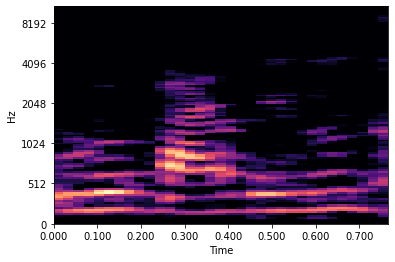

In [ ]:
#멜스펙트럼으로 변환

test_mel = librosa.feature.melspectrogram(y_test, sr=sr, n_mels=128, fmax=8000)
test_mel_db = librosa.amplitude_to_db(np.abs(test_mel), ref=np.max)
librosa.display.specshow(test_mel_db,  x_axis='time', y_axis='mel')

plt.show()

#4.음성 데이터 증강

- 화이트 노이즈 추가
- shiftinf 추가
- Stretching 추가(주의: 늘어지더라도 음성데이터 길이는 통일 시켜야 함)
- Minus추가
- 피치 변경(음의 높이 또는 높낮이)


##4-1.음성데이터 증강을 위한 함수 생성하기


In [ ]:
#1.white Noise 만드는 함수

def add_white_noise(data, sr=22050, noise_rate=np.random.uniform(0,0.3)):
    wn = np.random.randn(len(data))
    data_wn = data + noise_rate*wn
    data_wn = data_wn.astype(type(data[0])) #노이즈 작업전 datatype으로 데이터 형태 변환

    return data_wn

In [ ]:
#2.Shifting 만드는 함수
def shifting_sound(data, sr=22050, roll_rate=0.1):
    # 그냥 [1, 2, 3, 4] 를 [4, 1, 2, 3]으로 만들어주는 방식
    data_roll = np.roll(data, int(len(data) * roll_rate))
    data_roll = data_roll.astype(type(data[0]))

    return data_roll


In [ ]:
#3. stretch_sound 만드는 함수
def stretch_sound(data, sr=22050, roll_rate=0.8):
    # 그냥 [1, 2, 3, 4] 를 [4, 1, 2, 3]으로 만들어주는 방식
    stretch_data = librosa.effects.time_stretch(data, roll_rate)
    stretch_data = stretch_data.astype(type(data[0]))

    #늘어나더라도 원본 데이터의 길이와 동일하게 잘라줌
    stretch_data = stretch_data[:len(data)]
    return stretch_data

In [ ]:
#4. 위상뒤집기
def minus_sound(data, sr=22050):
    # 위상을 뒤집는 것으로서 원래 소리와 똑같이 들린다.
    temp_numpy = (-1.3)*data
    return temp_numpy


In [ ]:
#5. 피치 조절
def change_pitch(data, sr=22050, pitch_factor=np.random.randint(-5,5)):
    ch_pi = librosa.effects.pitch_shift(data, sr, pitch_factor)
    return ch_pi



##4-2.전체 데이터에 대한 데이터 증강 실시

해당 배열과 동일한 zero배열을 만든 다음 음성 데이터 증강 함수를 사용해서 나온 결과(넘파일 배열)을 저장하는 방식

In [ ]:
#날리면 전체 넘파이 배열에 대해서 실시
#음성데이터 증강을 위해 넘파일 배열생성(shape은 동일하게 )
nali_array_ad = np.zeros_like(nali_array)
nali_array_sh = np.zeros_like(nali_array)
nali_array_st = np.zeros_like(nali_array)
nali_array_mi = np.zeros_like(nali_array)
nali_array_ch = np.zeros_like(nali_array)

#실제 데이터 증강 실시1
for i in range(len(nali_array)):
    nali_array_ad[i] = add_white_noise(nali_array[i])
    nali_array_sh[i] = shifting_sound(nali_array[i])
    nali_array_st[i] = stretch_sound(nali_array[i])
    nali_array_mi[i] = minus_sound(nali_array[i])
    nali_array_ch[i] = change_pitch(nali_array[i])


In [ ]:
#바이든 전체 넘파이 배열에 대해서 실시
#음성데이터 증강을 위해 넘파일 배열생성(shape은 동일하게 )
biden_array_ad = np.zeros_like(biden_array)
biden_array_sh = np.zeros_like(biden_array)
biden_array_st = np.zeros_like(biden_array)
biden_array_mi = np.zeros_like(biden_array)
biden_array_ch = np.zeros_like(biden_array)

#실제 데이터 증강 실시2
for i in range(len(biden_array)):
    biden_array_ad[i] = add_white_noise(biden_array[i])
    biden_array_sh[i] = shifting_sound(biden_array[i])
    biden_array_st[i] = stretch_sound(biden_array[i])
    biden_array_mi[i] = minus_sound(biden_array[i])
    biden_array_ch[i] = change_pitch(biden_array[i])


In [ ]:
#unknown 전체 넘파이 배열에 대해서 실시
#음성데이터 증강을 위해 넘파일 배열생성(shape은 동일하게 )
unknown_array_ad = np.zeros_like(unknown_array)
unknown_array_sh = np.zeros_like(unknown_array)
unknown_array_st = np.zeros_like(unknown_array)
unknown_array_mi = np.zeros_like(unknown_array)
unknown_array_ch = np.zeros_like(unknown_array)

#실제 데이터 증강 실시3
for i in range(len(unknown_array)):
    unknown_array_ad[i] = add_white_noise(unknown_array[i])
    unknown_array_sh[i] = shifting_sound(unknown_array[i])
    unknown_array_st[i] = stretch_sound(unknown_array[i])
    unknown_array_mi[i] = minus_sound(unknown_array[i])
    unknown_array_ch[i] = change_pitch(unknown_array[i])

##4-3. 만들어진 음성데이터와 원본데이터 합치기

- 원본 데이터 배열: biden_array, nali_array, unknown_biden_array

- 만들어진 데이터 배열: 각각 5 묶음씩

unknown_array_ad
unknown_array_sh
unknown_array_st
unknown_array_mi
unknown_array_ch

In [ ]:
unknown_array_ad.shape


(24, 33075)

In [ ]:
nali_hap = np.concatenate([nali_array, nali_array_ad, nali_array_sh, nali_array_st,nali_array_mi, nali_array_ch])

biden_hap = np.concatenate([biden_array, biden_array_ad, biden_array_sh, biden_array_st,biden_array_mi, biden_array_ch])

unknown_hap = np.concatenate([unknown_array, unknown_array_ad, unknown_array_sh, unknown_array_st,unknown_array_mi, unknown_array_ch])

In [ ]:
nali_hap.shape

(144, 33075)

In [ ]:
#아무거나 하나 끄집어 내서 들어보자

display(Audio(data=biden_hap[100],rate=sr))


#5.음성데이터 특성 추출(MFCC활용)

librosa라이브러리의 mfcc메서드 활용
- librosa.feature.mfcc

1. MFCC(Mel-frequency cepstral coefficients)이란?
- Mel Scale Spectrum을 40개의 주파수 구역(band)으로 묶은뒤에 이를 다시 푸리에 변환하여 얻은 계수
- <font color='orange'> 스펙트럼이 어떤 모양으로 되어 있는지를 나타내는 특성값이라고 생각할 수 있음  </font>

2. 스펙트로그램과 비교하여 압축된 정보를 담고 있다고 생각할 수 있음
--> <font color='orange'> 오디오 신호 처리 분야에서 많이 사용되는 소리 데이터의 특징값(Feature)  </font>


3. 압축하는 과정에서 손실이 발생, 노이즈가 제거되는 효과가 있음
- 이 때문에 MFCC값이 고유의 음성 정보를 담고 있다고 보기도 함







##5-0.왜 mfcc를 쓰는가?

MFCC는 실제로 화자 검증에 사용되기도 함

1. 화자 검증이란?
-  화자 인식(Speaker Recognition)의 세부 분류로서 말하는 사람이 그 사람이 맞는지를 확인하는 기술

- 시스템에 등록된 음성에만 반응하는 아이폰의 Siri를 예로 들 수 있음

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2Fcx2JPl%2FbtqwJdUKjCP%2F37FYIXkaIKh0xaOlpUtjT1%2Fimg.png)

<font color='orange'> MFCC는 등록된 음성과 현재 입력된 음성의 유사도를 판별하는 근거의 일부로 쓰임  </font>

2. 음악 장르 분류

- MFCC는 음성뿐만 아니라 음악 신호에서도 사용됨

- 화자 인식에서 화자의 특징을 표현할 수 있는 것처럼, 음악의 특징도 MFCC로 표현할 수 있음

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbPwI1H%2FbtqwHrtD8Qt%2FRNhk3kF4txZ6cgNaYB52V0%2Fimg.png)




##5-1.전체 데이터에 대해 mfcc값 추출

In [ ]:
#일단 1개 음성데이터만 mfcc값 추출

nali_mfccs_sample = librosa.feature.mfcc(y=nali_hap[1], sr=sr, n_mfcc=40)
nali_mfccs_sample.shape

(40, 65)

In [ ]:
# 위와 비슷한 방식으로 진행
# 빈 리스트 생성 후 값을 저장한 다음 넘파이 배열로 전환

nali_mfccs = []
biden_mfccs = []
unknown_mfccs = []

for i in range(len(nali_hap)):
    nali_mfccs_temp = librosa.feature.mfcc(y=nali_hap[i], sr=sr, n_mfcc=40)
    nali_mfccs.append(nali_mfccs_temp)

for i in range(len(biden_hap)):
    biden_mfccs_temp = librosa.feature.mfcc(y=biden_hap[i], sr=sr, n_mfcc=40)
    biden_mfccs.append(biden_mfccs_temp)

for i in range(len(unknown_hap)):
    unknown_mfccs_temp = librosa.feature.mfcc(y=unknown_hap[i], sr=sr, n_mfcc=40)
    unknown_mfccs.append(unknown_mfccs_temp)


#넘파이 배열로

nali_mfccs = np.array(nali_mfccs)
biden_mfccs = np.array(biden_mfccs)
unknown_mfccs = np.array(unknown_mfccs)

In [ ]:
#하나의 값 살펴보기
#주파수 밴드값 40개에 따른 값이 순차적으로 들어가 있음을 확인할 수 있음

print("shape살펴보기:", nali_mfccs[1].shape)
nali_mfccs[1]

shape살펴보기: (40, 65)


array([[-4.9913110e+02, -4.9564725e+02, -4.4911636e+02, ...,
        -4.5145660e+02, -4.6994110e+02, -4.5325845e+02],
       [ 1.4472638e+02,  1.4387582e+02,  1.4847940e+02, ...,
         1.9463066e+02,  1.7764575e+02,  1.3753247e+02],
       [-1.8510242e+01, -2.3417854e+01, -6.9817963e+01, ...,
         3.1735673e+00,  8.2743955e-01, -4.1717415e+00],
       ...,
       [ 4.9690666e+00, -1.7284507e-01, -4.4170580e+00, ...,
        -5.6388407e+00, -5.0381413e+00, -2.0909133e+00],
       [ 1.7101547e+00, -1.2693932e+00, -4.0835123e+00, ...,
        -5.2187524e+00, -3.9217792e+00, -1.8445814e+00],
       [ 2.1824310e+00, -1.0145913e+00, -6.0215058e+00, ...,
        -3.6354408e+00, -4.1027632e+00, -7.1901979e+00]], dtype=float32)

In [ ]:
#3개의 배열을 합하여 train_data 셋 만들기

train = np.concatenate([nali_mfccs, biden_mfccs, unknown_mfccs])
train.shape


(432, 40, 65)

In [ ]:
len(train)

432

##5-2.원핫인코딩을 통해 라벨링

In [ ]:
# 라벨 딕셔너리 생성
labels_dic = { 0:'nali', 1:'biden', 2:"unknown"}

In [ ]:
# train_hap의 길이와 동일한 1차원 배열 선언

labels_hap = np.array(range(len(train)))

labels_hap[:len(nali_mfccs)] = 0
labels_hap[len(nali_mfccs): len(nali_mfccs) + len(biden_mfccs) ] = 1
labels_hap[len(nali_mfccs) + len(biden_mfccs):] = 2

In [ ]:
#전체 라벨 살펴보기
labels_hap

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
#원핫 인코딩
labels = tf.keras.utils.to_categorical(labels_hap)
print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


##5-3.넘파이값 중간저장

여기까지 생성된 넘파이 배열값을 중간저장해보기

쭉이어서 실습하는 경우 생략 가능

In [ ]:
#넘파이 배열값 저장하기
np.savez('/content/drive/MyDrive/Colab Notebooks/8.음향관련/np_biden_nali/biden_nali.npz', x=train, y=labels) #각각 이름 붙여줘야 불러오기 가능

In [ ]:
#저장된 넘파이 값 불러오기

data = np.load('/content/drive/MyDrive/Colab Notebooks/8.음향관련/np_biden_nali/biden_nali.npz')

In [ ]:
# 불러온 넘파이 배열 객체의 요소들 살펴보기
list(data)

['x', 'y']

In [ ]:
# 저장된 값 확인
# 이때 data안의 x인자와 y인자로 다시 train과 labels를 지정하면 됨

train = data['x']
labels = data['y']

#잘 불러와졌는지 확인
train.shape

(432, 40, 65)

In [ ]:
# 1개 데이터 살펴보기

train[55]

array([[-4.83834320e+02, -4.83996277e+02, -4.84481476e+02, ...,
        -4.82637756e+02, -4.82680634e+02, -4.86989105e+02],
       [ 1.21324005e+02,  1.20631393e+02,  1.20195267e+02, ...,
         1.24392509e+02,  1.23863632e+02,  1.20799362e+02],
       [-1.02695389e+01, -1.37395544e+01, -1.67605057e+01, ...,
        -9.40140152e+00, -9.73761177e+00, -7.89217091e+00],
       ...,
       [-3.80666947e+00, -6.05301142e+00, -4.73792934e+00, ...,
        -2.15809703e+00, -8.46395493e-01, -2.19410419e+00],
       [-5.62515259e+00, -4.93004513e+00, -3.55079627e+00, ...,
        -5.27484715e-03, -9.71386909e-01, -6.19279575e+00],
       [-1.36664093e+00, -2.73922086e-03,  2.18685985e-01, ...,
        -2.28000402e-01, -4.49086964e-01, -5.06572390e+00]], dtype=float32)

##5-4.훈련 데이터 셋, 검증 데이터 셋을 만들기

In [ ]:
#사이킷런 라이브러리 활용
from sklearn.model_selection import train_test_split

train_sound, test_sound, train_labels, test_labels = train_test_split(train, labels, test_size=0.2, random_state = 42)

#훈련 데이터셋 살펴보기

train_sound.shape

(345, 40, 65)

In [ ]:
#훈련 데이터 라벨 살펴보기
train_labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
#훈련데이터 하나를 음성으로 다시 변환해서 들어보고

temp = librosa.feature.inverse. mfcc_to_audio(train_sound[130])
display(Audio(data=temp,rate=sr))

In [ ]:
#라벨링이 맞게 되어 있는지 확인

train_labels[130]

# labels_dic = { 0:'nali', 1:'biden', 2:"unknown"}

array([1., 0., 0.], dtype=float32)

#6.CNN모델 만들기(3개 클래스)

##6-1.관련 메서드 불러오기

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten,Dropout, GlobalAvgPool2D


##6-2.모델 만들기

다중분류로 진행하므로 손실함수는 바이너리 크로스 엔트로피가 아닌 categorical_cross_entropy 사용

In [ ]:
#함수형 API사용
# input데이터의 shape는 (배치, 40, 65)
# output데이터의 shape는 (배치,3)  여기서3은 바이든, 날리면, 모르겠다

# 1번 모델은 풀링없이
def biden_nali_model1():
    inputs = tf.keras.Input(shape=(40, 65,1))

    x1 = Conv2D(16,2,activation= 'relu', padding='same')(inputs)
    x1 = Dropout(0.2)(x1)

    x2 = Conv2D(32,2,activation= 'relu', padding='same')(x1)
    x2 = MaxPool2D(2)(x2)
    x2 = Dropout(0.2)(x2)

    x3 = Conv2D(32,2,activation= 'relu', padding='same')(x2)
    x3 = Dropout(0.2)(x3)

    x4 = Conv2D(64,2,activation= 'relu', padding='same')(x3)
    x4 = Dropout(0.2)(x4)

    x5 = Conv2D(128,2,activation= 'relu')(x4)
    x5 = MaxPool2D(2)(x5)

    #마지막 단계에서는 dropout생략

    x6 = GlobalAvgPool2D()(x5)
    outputs = Dense(3, activation='softmax')(x6)

    model = Model(inputs,outputs)
    return model


In [ ]:
def biden_nali_model2():
    inputs = tf.keras.Input(shape=(40, 65,1))

    x1 = Conv2D(16,2,activation= 'relu')(inputs)
    x1 = MaxPool2D(2)(x1)
    x1 = Dropout(0.2)(x1)

    x2 = Conv2D(32,2,activation= 'relu')(x1)
    x2 = MaxPool2D(2)(x2)
    x2 = Dropout(0.2)(x2)

    x3 = Conv2D(32,2,activation= 'relu')(x2)
    x3 = MaxPool2D(2)(x3)
    x3 = Dropout(0.2)(x3)

    x4 = Conv2D(64,2,activation= 'relu')(x3)
    x4 = MaxPool2D(2)(x4)
    x4 = Dropout(0.2)(x4)

    #마지막 단계에서는 dropout생략

    x5 = Flatten()(x4)
    outputs = Dense(3, activation='softmax')(x5)

    model = Model(inputs,outputs)
    return model

In [ ]:
# 모델 만들고 모델 구조 확인

model1 = biden_nali_model1()
model2 = biden_nali_model2()


In [ ]:
# 1번 모델의 구조
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 65, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 65, 16)        80        
                                                                 
 dropout (Dropout)           (None, 40, 65, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 65, 32)        2080      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 32, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 20, 32, 32)        0         
                                                             

In [ ]:
# 2번 모델의 구조
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 65, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 39, 64, 16)        80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 19, 32, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 31, 32)        2080      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 15, 32)        0         
 2D)                                                       

In [ ]:
# 옵티마이져 설정
opt1 = tf.keras.optimizers.Adam(learning_rate=0.001)
opt2 = tf.keras.optimizers.Adam(learning_rate=0.0005)

model1.compile(loss = 'categorical_crossentropy',  optimizer=opt1, metrics='accuracy')
model2.compile(loss = 'categorical_crossentropy',  optimizer=opt2, metrics='accuracy')

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)]

##6-3.학습시키기

In [ ]:
# train_expand_images, train_labels을 학습시키고 15 epochs을 돌리고 그 진행 사항을 hist1에 저장
# train_expand_images의 shape와 model의 input데이터의 shape이 다르기 때문에 reshape필요

hist1 = model1.fit(train_sound.reshape(-1,40,65,1), train_labels,
                   validation_data = (test_sound.reshape((-1,40,65,1)), test_labels),
                   batch_size = 128, epochs=500, verbose=1,  callbacks=callbacks)

Epoch 1/500
3/3 [==============================] - 9s 356ms/step - loss: 2.0974 - accuracy: 0.3304 - val_loss: 1.2585 - val_accuracy: 0.1839
Epoch 2/500
3/3 [==============================] - 0s 40ms/step - loss: 1.6718 - accuracy: 0.2870 - val_loss: 1.1025 - val_accuracy: 0.2184
Epoch 3/500
3/3 [==============================] - 0s 38ms/step - loss: 1.1387 - accuracy: 0.3565 - val_loss: 1.1663 - val_accuracy: 0.2644
Epoch 4/500
3/3 [==============================] - 0s 39ms/step - loss: 1.2203 - accuracy: 0.3507 - val_loss: 1.1778 - val_accuracy: 0.2644
Epoch 5/500
3/3 [==============================] - 0s 38ms/step - loss: 1.1593 - accuracy: 0.3507 - val_loss: 1.1183 - val_accuracy: 0.4023
Epoch 6/500
3/3 [==============================] - 0s 39ms/step - loss: 1.0932 - accuracy: 0.3739 - val_loss: 1.0861 - val_accuracy: 0.3448
Epoch 7/500
3/3 [==============================] - 0s 37ms/step - loss: 1.0788 - accuracy: 0.4319 - val_loss: 1.0725 - val_accuracy: 0.5747
Epoch 8/500
3/3 [==

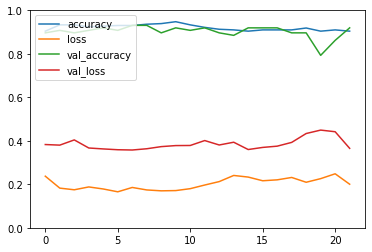

In [ ]:
#학습 진행사항을 plt로 출력
# hist1의 accuracy plt의 plot을 이용하여 출력

plt.plot(hist1.history['accuracy'], label='accuracy')
plt.plot(hist1.history['loss'], label='loss')
plt.plot(hist1.history['val_accuracy'], label='val_accuracy')
plt.plot(hist1.history['val_loss'], label='val_loss')
plt.ylim(0.0, 1.0)
plt.legend(loc='upper left')
plt.show()


In [ ]:
# model2는 조기 종료 없이 진행
hist2 = model2.fit(train_sound.reshape(-1,40,65,1), train_labels,
                   validation_data = (test_sound.reshape((-1,40,65,1)), test_labels),
                   batch_size=128, epochs=1000, verbose=1)

Epoch 1/1000
3/3 [==============================] - 1s 207ms/step - loss: 10.6634 - accuracy: 0.3333 - val_loss: 1.8911 - val_accuracy: 0.4138
Epoch 2/1000
3/3 [==============================] - 0s 19ms/step - loss: 8.8385 - accuracy: 0.3594 - val_loss: 1.6298 - val_accuracy: 0.4253
Epoch 3/1000
3/3 [==============================] - 0s 20ms/step - loss: 8.1504 - accuracy: 0.2667 - val_loss: 1.3170 - val_accuracy: 0.4253
Epoch 4/1000
3/3 [==============================] - 0s 19ms/step - loss: 6.3507 - accuracy: 0.3797 - val_loss: 1.2881 - val_accuracy: 0.4483
Epoch 5/1000
3/3 [==============================] - 0s 22ms/step - loss: 6.8481 - accuracy: 0.2928 - val_loss: 1.1463 - val_accuracy: 0.4368
Epoch 6/1000
3/3 [==============================] - 0s 23ms/step - loss: 5.4418 - accuracy: 0.3188 - val_loss: 1.1798 - val_accuracy: 0.4023
Epoch 7/1000
3/3 [==============================] - 0s 21ms/step - loss: 5.6249 - accuracy: 0.3391 - val_loss: 1.1693 - val_accuracy: 0.4253
Epoch 8/100

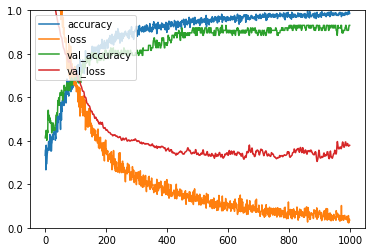

In [ ]:
#학습 진행사항을 plt로 출력
# hist2의 accuracy plt의 plot을 이용하여 출력

plt.plot(hist2.history['accuracy'], label='accuracy')
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_accuracy'], label='val_accuracy')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.ylim(0.0, 1.0)
plt.show()

##6-4.모델 평가하기



In [ ]:
#1번 모델 평가

model1.evaluate(test_sound.reshape(-1,40,65,1), test_labels, batch_size=32)

3/3 [==============================] - 0s 51ms/step - loss: 0.3654 - accuracy: 0.9195


[0.36540985107421875, 0.9195402264595032]

In [ ]:
#2번 모델 평가

model2.evaluate(test_sound.reshape(-1,40,65,1), test_labels, batch_size=32)

3/3 [==============================] - 0s 32ms/step - loss: 0.3797 - accuracy: 0.9310


[0.3796848952770233, 0.931034505367279]

##6-5.테스트

해당 음성 데이터를 불러온 다음

mfcc변환한 값으로 테스트 해야 함


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/8.음향관련/sj_sound_data/test/test1.wav'

test_yun_sound, sr = librosa.load(file_path)

In [ ]:
#테스트 사운드 들어보기

display(Audio(data=test_yun_sound,rate=sr))

In [ ]:
#mfcc값으로 변환 전 음성데이터 길이 조절
max_len = 33075
zero_padding = tf.zeros(max_len - tf.shape(test_yun_sound), dtype=tf.float32)
test_yun_sound = tf.concat([test_yun_sound, zero_padding],0)
test_yun_sound = np.array(test_yun_sound)
type(test_yun_sound)

numpy.ndarray

In [ ]:
#zero패딩된 테스트 음성 다시 들어보기
display(Audio(data=test_yun_sound,rate=sr))

In [ ]:
#모델 주입전 mfcc값으로 변환

test_yun_mfcc = librosa.feature.mfcc(y=test_yun_sound, sr=sr, n_mfcc=40)
test_yun_mfcc.shape

(40, 65)

In [ ]:
#모델에 주입하기 위해 shape 확인후 변환
#우리가 주입해야할 shape는 40,65인데 현재 yun데이터는 40,33
test_yun = test_yun_mfcc.reshape(1, 40, 65, 1)
test_yun.shape

(1, 40, 65, 1)

In [ ]:
#test 데이터를 2개의 모델에 주입

yun_result1 = model1.predict(test_yun)
yun_result2 = model2.predict(test_yun)

1/1 [==============================] - 0s 64ms/step


In [ ]:
# 결과확인1-숫자로

print("1번 모델의 결과:", yun_result1)
print("2번 모델의 결과:", yun_result2)

1번 모델의 결과: [[8.4320849e-01 2.6454317e-04 1.5652700e-01]]
2번 모델의 결과: [[0.80751425 0.05412688 0.1383589 ]]


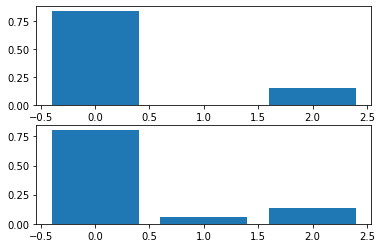

날리면이면 0, 바이든이면1, cnn모델도 모르겠으면 2


In [ ]:
#결과 확인2-그래프로

plt.subplot(2,1,1)
plt.bar(range(3), yun_result1[0])

plt.subplot(2,1,2)
plt.bar(range(3), yun_result2[0])
plt.show()

print("날리면이면 0, 바이든이면1, cnn모델도 모르겠으면 2")

# labels_dic = { 0:'nali', 1:'biden', 2:"unknown"}

In [ ]:
#결과가 이상하니 잡음제거 안된 원본 음성으로

file_path2 = '/content/drive/MyDrive/Colab Notebooks/8.음향관련/sj_sound_data/test/test_yun(잡음포함).wav'

test_yun_sound2, sr = librosa.load(file_path2)
display(Audio(data=test_yun_sound2,rate=sr))

In [ ]:
test_yun_sound2.shape

(33075,)

In [ ]:
# 리브로사 라이브러리로 mfcc변환
test_yun_mfcc2 = librosa.feature.mfcc(y=test_yun_sound2, sr=sr, n_mfcc=40)
test_yun2 = test_yun_mfcc2.reshape(1, 40, 65, 1)


In [ ]:
# 학습된 모델에 넣고 예측하기
yun_result3 = model1.predict(test_yun2)
yun_result4 = model2.predict(test_yun2)


1/1 [==============================] - 0s 16ms/step


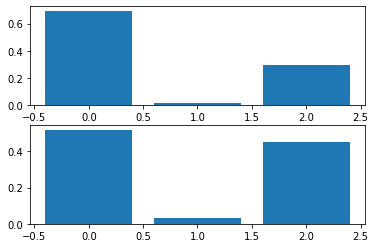

날리면이면 0, 바이든이면1, cnn모델도 모르겠으면 2


In [ ]:
#결과 확인2-그래프로

plt.subplot(2,1,1)
plt.bar(range(3), yun_result3[0])

plt.subplot(2,1,2)
plt.bar(range(3), yun_result4[0])
plt.show()

print("날리면이면 0, 바이든이면1, cnn모델도 모르겠으면 2")

# labels_dic = { 0:'nali', 1:'biden', 2:"unknown"}

#7.클래스를 3개에서 2개로


이진분류로 진행하므로 손실함수는 바이너리 크로스 엔트로피 사용

In [ ]:
# 저장된 값 확인
# 이때 data안의 x인자와 y인자로 다시 train과 labels를 지정하면 됨

train = data['x']
labels = data['y']

#잘 불러와졌는지 확인
train.shape

(432, 40, 65)

##7-1.라벨링 다시

In [ ]:
train2 = train[:288]

In [ ]:
labels_hap2 = np.array(range(len(train[:288])))

labels_hap2[:144] = 0
labels_hap2[144: ] = 1
labels2 = tf.keras.utils.to_categorical(labels_hap2)
labels2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [ ]:
train_sound2, test_sound2, train_labels2, test_labels2 = train_test_split(train2, labels2, test_size=0.2, random_state = 42)


##7-2.모델 다시

In [ ]:
def biden_nali_model3():
    inputs = tf.keras.Input(shape=(40, 65,1))

    x1 = Conv2D(16,2,activation= 'relu', padding='same')(inputs)
    # x1 = MaxPool2D(2)(x1)
    x1 = Dropout(0.2)(x1)

    x2 = Conv2D(32,2,activation= 'relu')(x1)
    x2 = MaxPool2D(2)(x2)
    x2 = Dropout(0.2)(x2)

    x3 = Conv2D(32,2,activation= 'relu', padding='same')(x2)
    # x3 = MaxPool2D(2)(x3)
    x3 = Dropout(0.2)(x3)

    x4 = Conv2D(64,2,activation= 'relu')(x3)
    x4 = MaxPool2D(2)(x4)
    x4 = Dropout(0.2)(x4)

    x5 = Conv2D(128,2,activation= 'relu')(x4)
    x5 = MaxPool2D(2)(x5)

    #마지막 단계에서는 dropout생략

    x6 = GlobalAvgPool2D()(x5)
    outputs = Dense(2, activation='softmax')(x6)

    model = Model(inputs,outputs)
    return model

In [ ]:
def biden_nali_model4():
    inputs = tf.keras.Input(shape=(40, 65,1))

    x1 = Conv2D(16,2,activation= 'relu')(inputs)
    x1 = MaxPool2D(2)(x1)
    x1 = Dropout(0.2)(x1)

    x2 = Conv2D(32,2,activation= 'relu')(x1)
    x2 = MaxPool2D(2)(x2)
    x2 = Dropout(0.2)(x2)

    x3 = Conv2D(32,2,activation= 'relu')(x2)
    x3 = MaxPool2D(2)(x3)
    x3 = Dropout(0.2)(x3)

    x4 = Conv2D(64,2,activation= 'relu')(x3)
    x4 = MaxPool2D(2)(x4)
    x4 = Dropout(0.2)(x4)

    #마지막 단계에서는 dropout생략

    x5 = Flatten()(x4)
    outputs = Dense(2, activation='softmax')(x5)

    model = Model(inputs,outputs)
    return model

In [ ]:
# 모델 서머리 확인

model3 = biden_nali_model3()
model4 = biden_nali_model4()
model3.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 40, 65, 1)]       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 40, 65, 16)        80        
                                                                 
 dropout_40 (Dropout)        (None, 40, 65, 16)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 39, 64, 32)        2080      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 19, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 19, 32, 32)        0         
                                                          

In [ ]:
opt1 = tf.keras.optimizers.Adam(learning_rate=0.001)
opt2 = tf.keras.optimizers.Adam(learning_rate=0.0005)

model3.compile(loss = 'binary_crossentropy',  optimizer=opt1, metrics='accuracy')
model4.compile(loss = 'binary_crossentropy',  optimizer=opt2, metrics='accuracy')

##7-3.학습다시

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]

In [ ]:
hist3 = model3.fit(train_sound2.reshape(-1,40,65,1), train_labels2,
                   validation_data = (test_sound2.reshape((-1,40,65,1)), test_labels2),
                   batch_size = 128, epochs=1000, verbose=1,  callbacks=callbacks)

Epoch 1/1000
2/2 [==============================] - 0s 70ms/step - loss: 0.1764 - accuracy: 0.9348 - val_loss: 0.4788 - val_accuracy: 0.8621
Epoch 2/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.1604 - accuracy: 0.9391 - val_loss: 0.3853 - val_accuracy: 0.8966
Epoch 3/1000
2/2 [==============================] - 0s 45ms/step - loss: 0.1690 - accuracy: 0.9435 - val_loss: 0.4133 - val_accuracy: 0.8966
Epoch 4/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.1601 - accuracy: 0.9391 - val_loss: 0.3938 - val_accuracy: 0.8793
Epoch 5/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.1546 - accuracy: 0.9435 - val_loss: 0.3884 - val_accuracy: 0.8793
Epoch 6/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.1446 - accuracy: 0.9652 - val_loss: 0.4432 - val_accuracy: 0.8621
Epoch 7/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1507 - accuracy: 0.9391 - val_loss: 0.3808 - val_accuracy: 0.8966
Epoch 8/1000


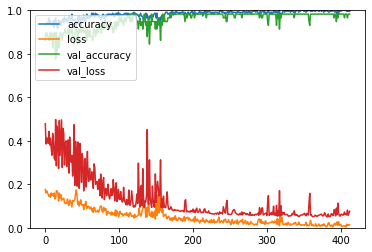

In [ ]:
#학습 진행사항을 plt로 출력
# hist3의 accuracy plt의 plot을 이용하여 출력

plt.plot(hist3.history['accuracy'], label='accuracy')
plt.plot(hist3.history['loss'], label='loss')
plt.plot(hist3.history['val_accuracy'], label='val_accuracy')
plt.plot(hist3.history['val_loss'], label='val_loss')
plt.ylim(0.0, 1.0)
plt.legend(loc='upper left')
plt.show()


In [ ]:
hist4 = model4.fit(train_sound2.reshape(-1,40,65,1), train_labels2,
                   validation_data = (test_sound2.reshape((-1,40,65,1)), test_labels2),
                   batch_size=128, epochs=3000, verbose=1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2/2 [==============================] - 0s 33ms/step - loss: 0.0497 - accuracy: 0.9957 - val_loss: 0.1189 - val_accuracy: 0.9310
Epoch 502/3000
2/2 [==============================] - 0s 31ms/step - loss: 0.0970 - accuracy: 0.9696 - val_loss: 0.1169 - val_accuracy: 0.9310
Epoch 503/3000
2/2 [==============================] - 0s 35ms/step - loss: 0.0817 - accuracy: 0.9696 - val_loss: 0.1158 - val_accuracy: 0.9310
Epoch 504/3000
2/2 [==============================] - 0s 30ms/step - loss: 0.0574 - accuracy: 0.9783 - val_loss: 0.1150 - val_accuracy: 0.9310
Epoch 505/3000
2/2 [==============================] - 0s 36ms/step - loss: 0.0391 - accuracy: 0.9826 - val_loss: 0.1141 - val_accuracy: 0.9310
Epoch 506/3000
2/2 [==============================] - 0s 31ms/step - loss: 0.0663 - accuracy: 0.9739 - val_loss: 0.1132 - val_accuracy: 0.9310
Epoch 507/3000
2/2 [==============================] - 0s 30ms/step - loss: 0.0539 - accuracy: 0.9870 - val_loss: 0.1126 -

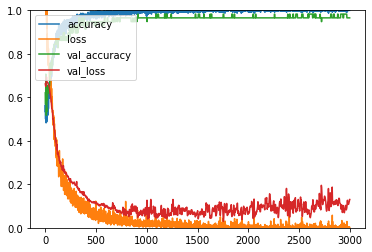

In [ ]:
#학습 진행사항을 plt로 출력
# hist4의 accuracy plt의 plot을 이용하여 출력

plt.plot(hist4.history['accuracy'], label='accuracy')
plt.plot(hist4.history['loss'], label='loss')
plt.plot(hist4.history['val_accuracy'], label='val_accuracy')
plt.plot(hist4.history['val_loss'], label='val_loss')
plt.ylim(0.0, 1.0)
plt.legend(loc='upper left')
plt.show()


##7-4.모델 평가하기

In [ ]:
# 3번 모델 평가하기
model3.evaluate(test_sound2.reshape(-1,40,65,1), test_labels2, batch_size=32)

2/2 [==============================] - 0s 96ms/step - loss: 0.0756 - accuracy: 0.9828


[0.07556033879518509, 0.982758641242981]

In [ ]:
# 4번 모델 평가하기
model4.evaluate(test_sound2.reshape(-1,40,65,1), test_labels2, batch_size=32)

2/2 [==============================] - 0s 62ms/step - loss: 0.1305 - accuracy: 0.9655


[0.130483940243721, 0.9655172228813171]

In [ ]:
# 학습된 모델에 넣고 예측하기
yun_result5 = model3.predict(test_yun)
yun_result6 = model4.predict(test_yun)

1/1 [==============================] - 0s 17ms/step


In [ ]:
print("1번 모델의 결과:", yun_result5)
print("2번 모델의 결과:", yun_result6)

1번 모델의 결과: [[1.000000e+00 7.845508e-21]]
2번 모델의 결과: [[0.00762401 0.992376  ]]


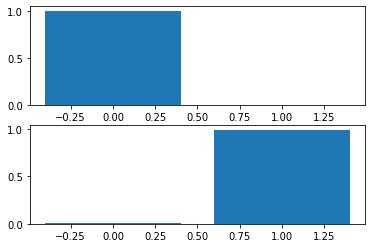

날리면이면 0, 바이든이면1


In [ ]:
# 시각화
plt.subplot(2,1,1)
plt.bar(range(2), yun_result5[0])

plt.subplot(2,1,2)
plt.bar(range(2), yun_result6[0])
plt.show()

print("날리면이면 0, 바이든이면1") #여기서는 클래스가 2개

# labels_dic = { 0:'nali', 1:'biden' }

#8.결론

1. CNN모델을 어떻게 구성하고, 어떤 데이터로 학습시키는지에 따라 예측결과는 상당히 달라질 수 있음

2. 멜스펙트럼으로 변환 했을때 시각적으로 분석한 결과는..